In [54]:
%load_ext autoreload
%autoreload 2

from model import LitS4Model
from data import LitDataModule
from plotting import *
import torch
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
#CHECKPOINT = '/home/lfd34/project/project8/ssm/neutrino_project/runs/input_I__output_energy_pitch__d_model_18_layers_6_gamma0.75_normX/lightning_logs/sa65jmgl/checkpoints/last.ckpt'
CHECKPOINT = '/home/lfd34/project/project8/ssm/neutrino_project/runs/noise_ts2channels_dmodel18_layers6_lr1e-3_gamma0.99/lightning_logs/ewvkwrnx/checkpoints/last.ckpt'

In [65]:
model = LitS4Model.load_from_checkpoint(CHECKPOINT)
model = model.to(device)
model = model.eval()

In [66]:
#dataset = LitDataModule.load_from_checkpoint(CHECKPOINT, inputs=['output_ts_I'], variables=model.variables)
dataset = LitDataModule.load_from_checkpoint(CHECKPOINT)

In [67]:
true = []
pred = []
meta = []

for ts,var,obs in dataset.test_dataloader():
    with torch.no_grad():
        pred.append(model(ts.to(device)).cpu().numpy())
        true.append(var.numpy())
        meta.append(obs.numpy())

In [68]:
#true = np.concatenate(true)
#pred = np.concatenate(pred)

true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)
meta = np.concatenate(meta, axis=0)

In [69]:
# undo the normalization
pred_post = pred * dataset.stds + dataset.mu
true_post = true * dataset.stds + dataset.mu

[]


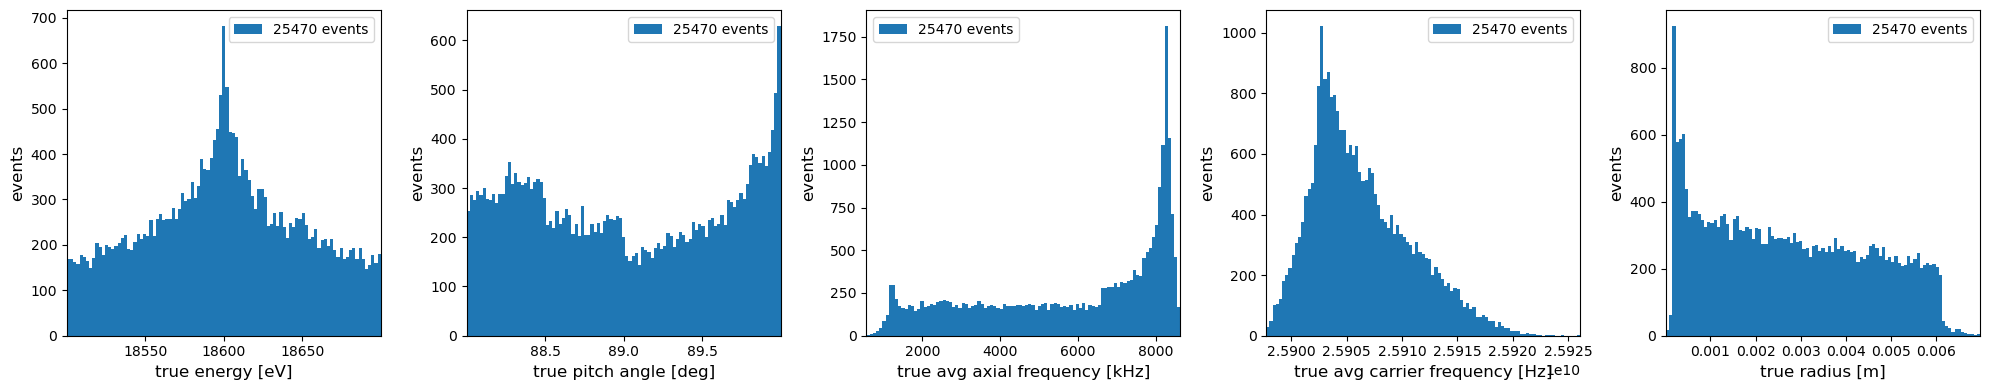

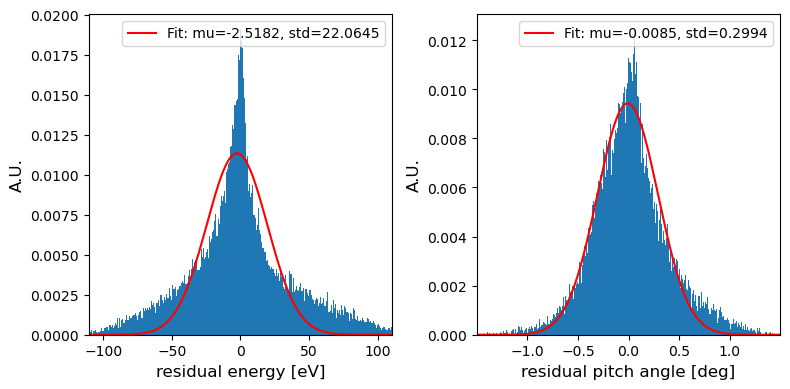

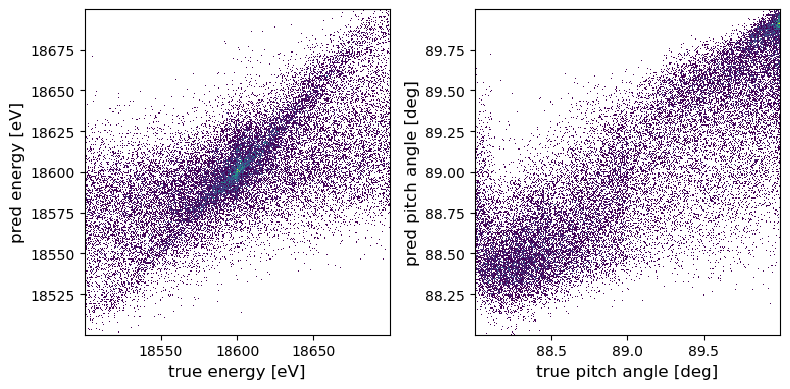

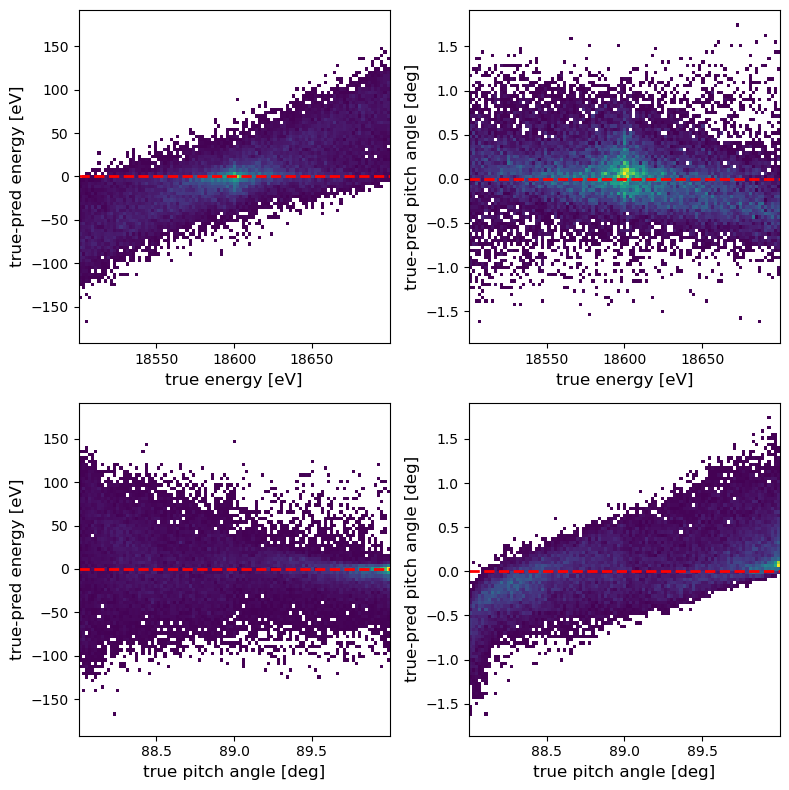

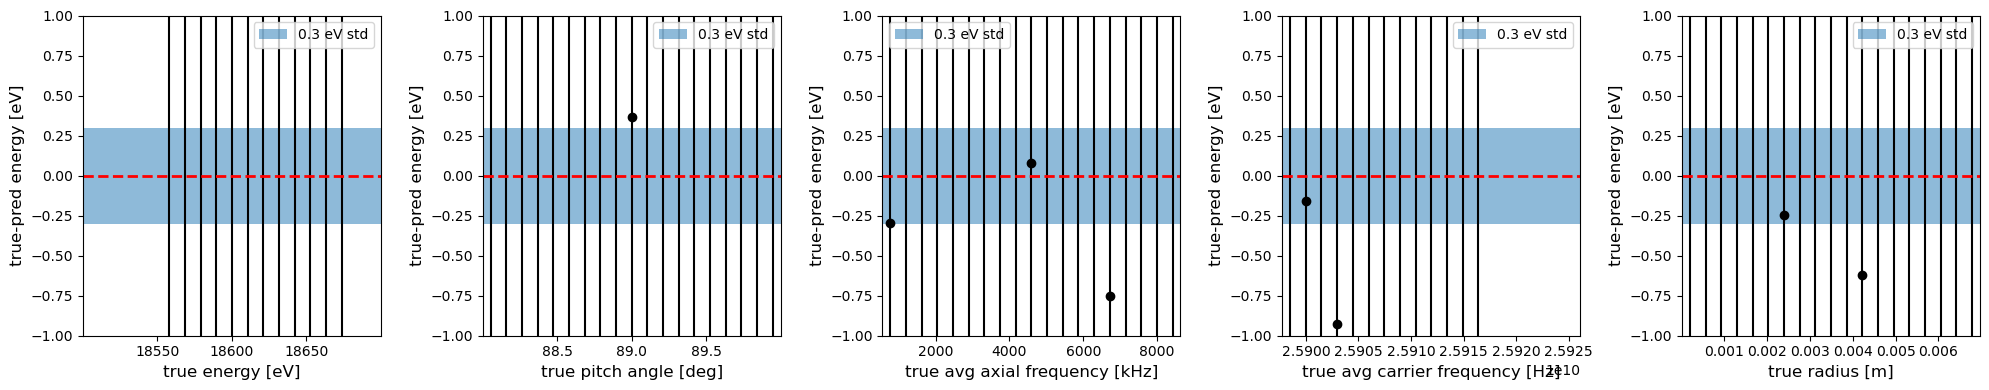

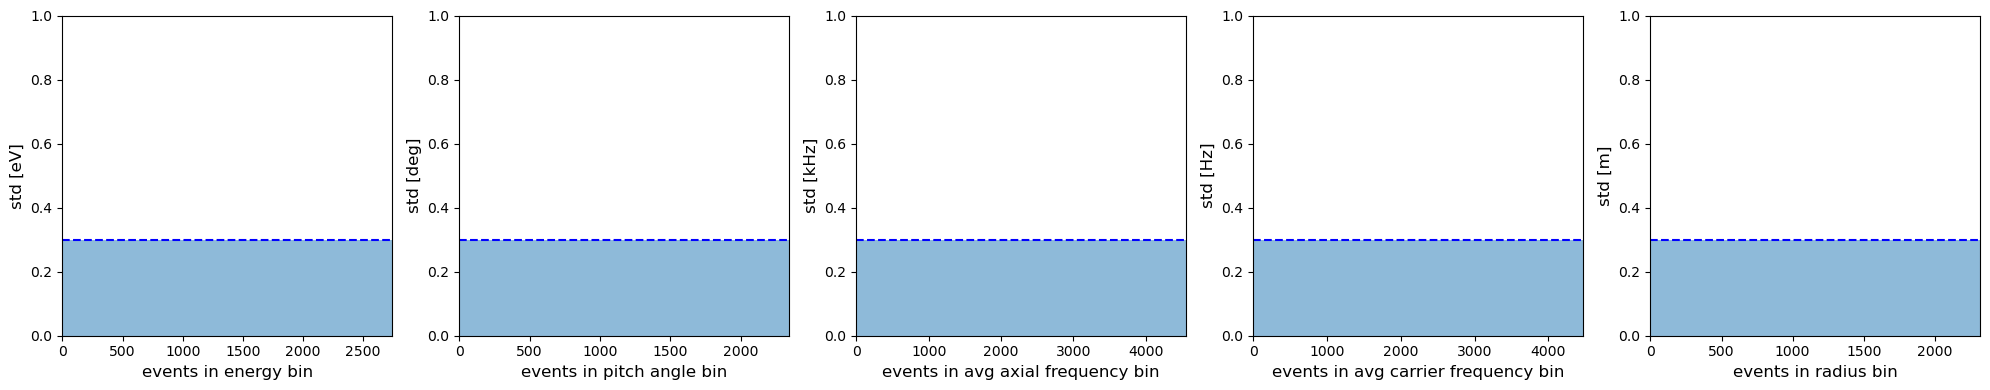

In [70]:
f = make_all_plots(dataset.variables, dataset.observables,true_post, pred_post, meta)

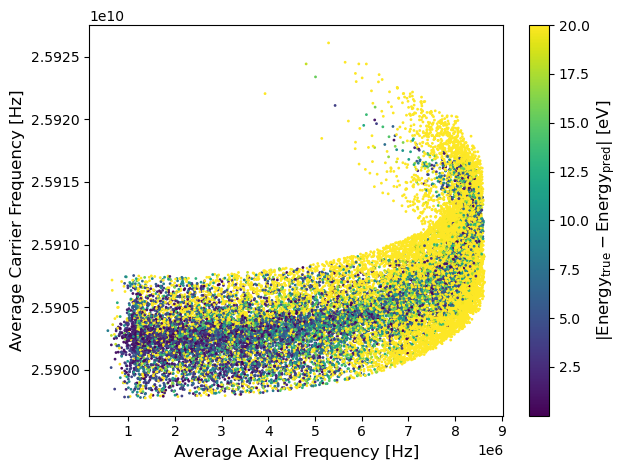

In [71]:
# true, pred: energy_eV, pitch_angle_deg
# meta: avg_axial_frequency_Hz, avg_carrier_frequency_Hz, radius_m

avg_axial_frequency_Hz = meta[:, 0]
avg_carrier_frequency_Hz = meta[:, 1]
true_energy = true_post[:, 0]
pred_energy = pred_post[:, 0]

fig, ax = plt.subplots()

sc = ax.scatter(
    avg_axial_frequency_Hz,
    avg_carrier_frequency_Hz,
    c=np.abs(true_energy - pred_energy),
    s=1,
    cmap='viridis', 
    vmax=20
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"$|\text{Energy}_{\text{true}} - \text{Energy}_{\text{pred}}|$ [eV]")

plt.xlabel("Average Axial Frequency [Hz]")
plt.ylabel("Average Carrier Frequency [Hz]")

plt.tight_layout()
plt.show()


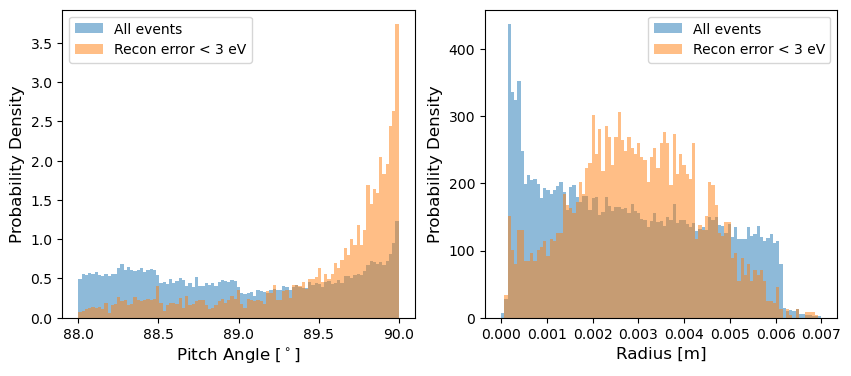

In [72]:
# true, pred: energy_eV, pitch_angle_deg
# meta: avg_axial_frequency_Hz, avg_carrier_frequency_Hz, radius_m

pitch_angle_bins = np.linspace(88, 90, 100)
radius_bins = np.linspace(0, 0.007, 100)

true_pitch_angles = true_post[:,1]
true_radii = meta[:,2]
true_energies = true_post[:,0]
pred_energies = pred_post[:,0]
recon_mask = np.abs(true_energies - pred_energies) < 3

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(true_pitch_angles, bins=pitch_angle_bins, density=True, alpha = 0.5, label="All events")
ax[0].hist(true_pitch_angles[recon_mask], bins=pitch_angle_bins, density=True, alpha = 0.5, label="Recon error < 3 eV")
ax[0].legend()
ax[0].set_xlabel(r"Pitch Angle [$^\circ$]")
ax[0].set_ylabel("Probability Density")
ax[1].hist(true_radii, bins=radius_bins, density=True, alpha = 0.5, label="All events")
ax[1].hist(true_radii[recon_mask], bins=radius_bins, density=True, alpha = 0.5, label="Recon error < 3 eV")
ax[1].set_xlabel(r"Radius [m]")
ax[1].set_ylabel("Probability Density")
ax[1].legend()
plt.show()